**IMPORTANT!**

Running everything at once might yeald strange results and I am not sure why.

If in 7) Evaluation the plots look strange and the explanations of the metrics don't match with the results, just rerun only the code of 5) Model building,
6) Training and 7) Evaluating, while ignoring the function definitions and imports. This fixes the problem.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# 1) Data Gathering

Here we gather the data (our csv) eiher by getting it directly from Kaggle using the given token file, or by uploading it manually.

**Important!**

This part requires you to upload into Google Colab your own Kaggle account api token. If you don't know how, follow Step 2 from the following guide and upload the downloaded file to Collab.

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

Alternatively, you can just import the .csv itself ("Admission_Predict_Ver1.1.csv").

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d mohansacharya/graduate-admissions

graduate-admissions.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip -u graduate-admissions.zip -d graduate-admissions

Archive:  graduate-admissions.zip


In [ ]:
try:
  data = pd.read_csv("graduate-admissions/Admission_Predict_Ver1.1.csv")
  print("Success")
except:
  data = pd.read_csv("Admission_Predict_Ver1.1.csv")
  print("You loaded manually")

Success


# 2) Data Visualization and Corelation

In [ ]:
# Method defines

# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.4, 0.1), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

Let's take a general look at our table and see what we are dealing with. 9 columns and 500 rows, out of wich Serial No. is just an indexing columns wich we will drop later.

In [ ]:
data

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73


We get some info on the data we have, to get a better feel. Here we see the type of each column and that we don't have any null values.

Note that Research is an int, not a bool.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


We drop the irrelevant Serial No. collumn.

Also, we take a more in dept look at the data, like the mean, the standard deviation and the min and max values of each columns.

The 25%, 50% and 75% are the percentiles, denoting which values are at the quarter, middle and 3 quarters in a ordered list. Basically 25% percentile has aprox. 25% of the values lower than it, same with the other 2.

In [ ]:
#Serian No. is irrelevant
data = data.drop(columns="Serial No.")
data.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


We take a look at the data distribution in plot format. As straightforward as it sounds.

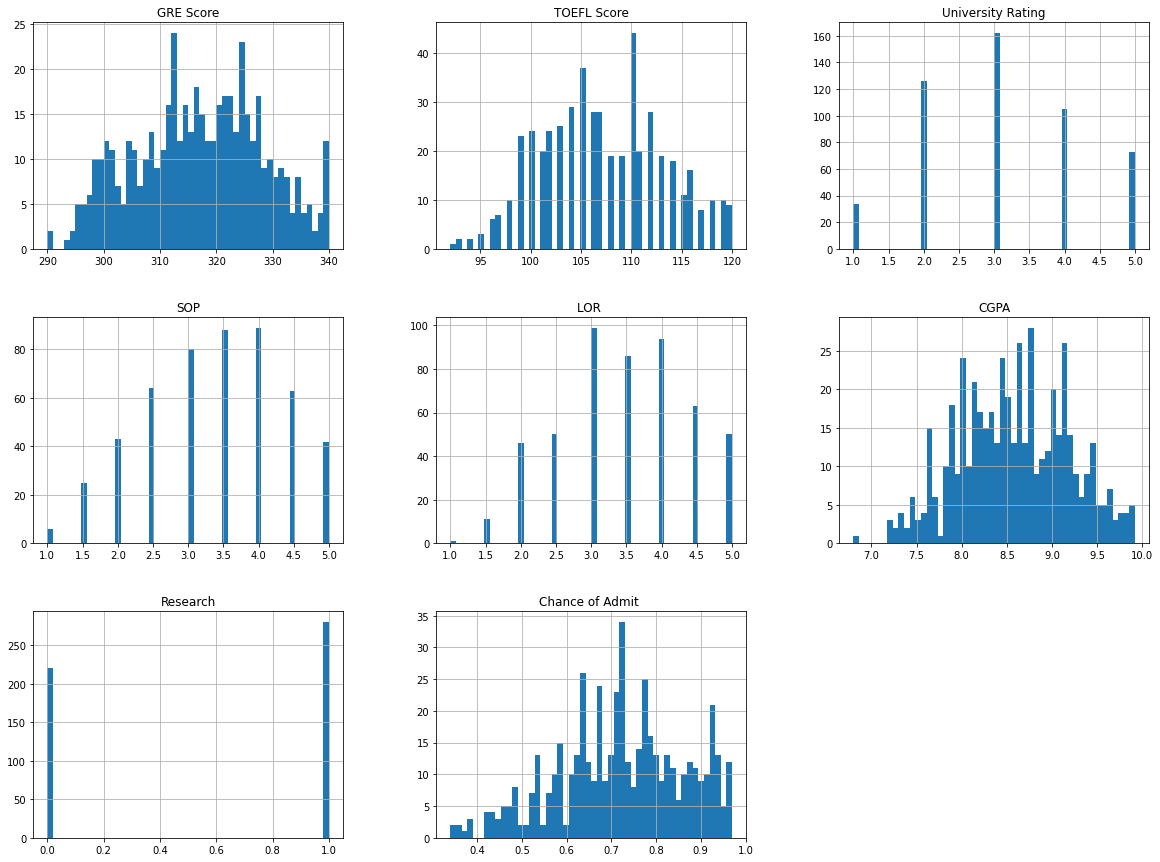

In [ ]:
%matplotlib inline
data.hist(bins=50, figsize=(20,15))

plt.show()

The corelation matrix shows us how useful the collumns are when trying to predict another one, strongly corelated having a similar increase between them, while weakly corelated columns are not so similar.

For example, research, which only has a 0 or 1 value, is not so useful when trying to corelate it with Chance of Admit, which has a wide veriety of values.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """


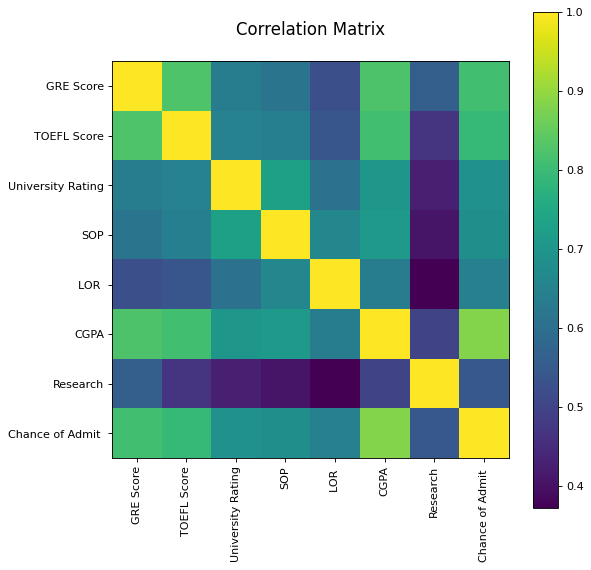

In [ ]:
plotCorrelationMatrix(data, 8)

This plot puts all columns two by two, to get a 2D representation of the pair values. From this, we can see that a linear regression model would do pretty well, as the values tend to increase and decrease together, in a liniar format.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


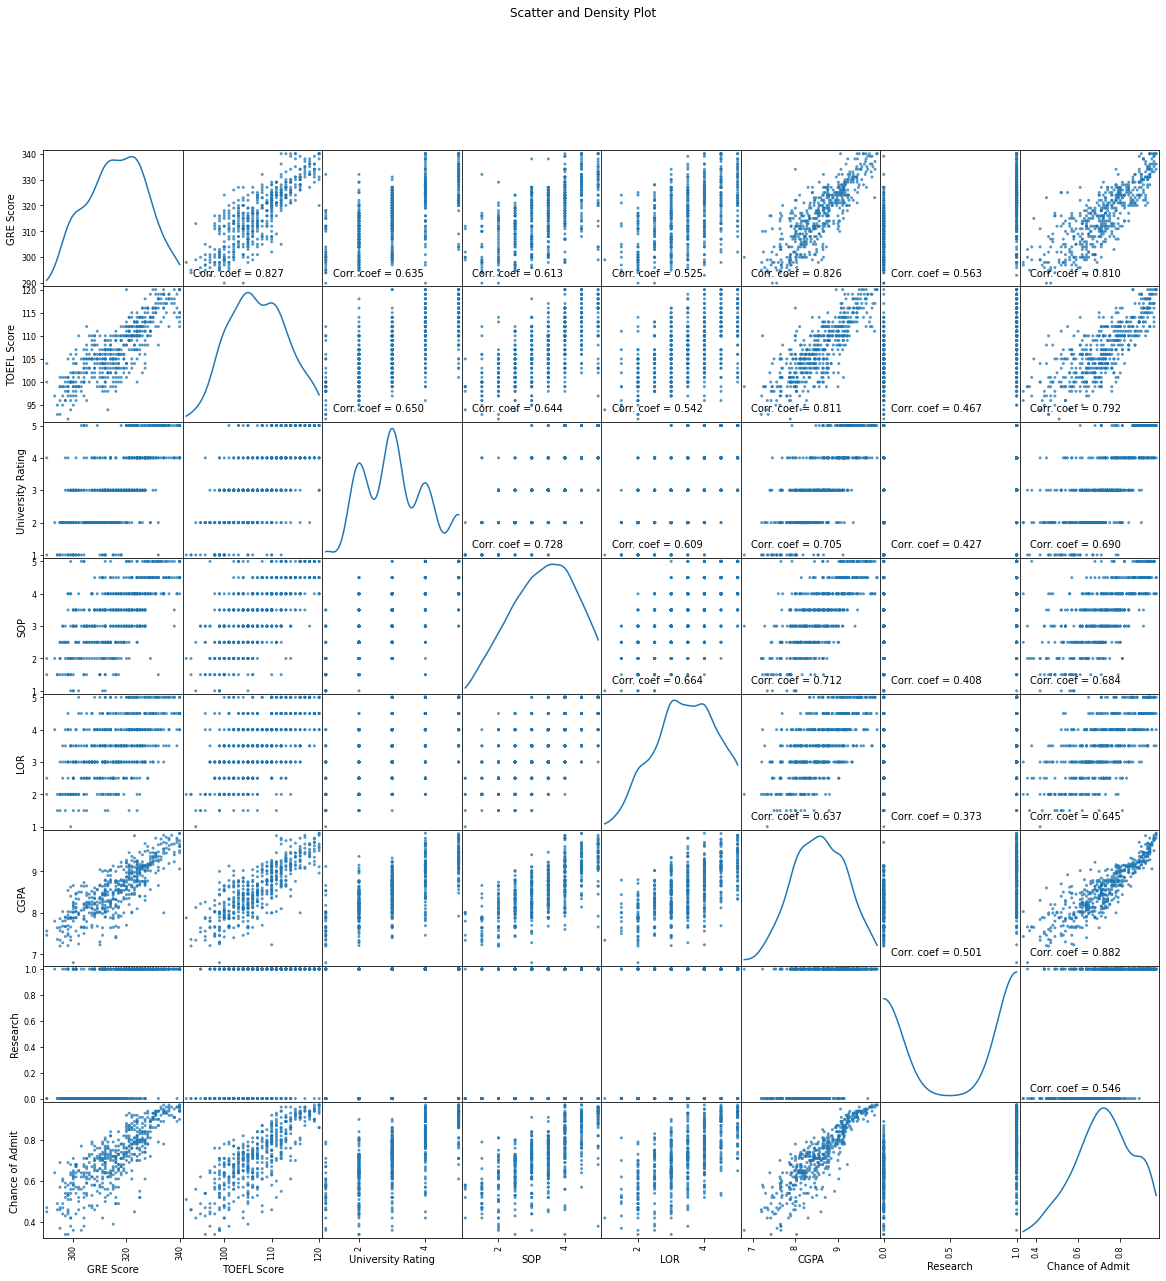

In [ ]:
plotScatterMatrix(data, 20, 10)

  As we can observe from both the corelation heatmap and the graphs, the Chance of Admittion has a very high corelation with the CGPA, a high corelation with GRE and TOEFL scores and a decent corelation with with the rest, except Research which has a very low corelation.

# 3) Data Cleaning

We already removed the irelevant column Serial No., and, even if Research has a very low corelation, it is still above 0.5 so we will keep it.

Now we will check if there are any NULL or NaN values in the dataset and replace them if need be.

In [ ]:
# in case you didn't run that part of the code
try:
  data = data.drop(columns="Serial No.")
except:
  pass

In [ ]:
# I read somewhere that you should only replace NaN with the mean only after you
# split it into training and testing, but I don't think it is such a big deal

for c in data.columns:
  if data[c].isnull().values.any():
    print(f"Column {c} has {data[c].isnull().sum()} null values, replacing them with the mean")
    col_mean = data[c].mean()
    if data[c].dtype == "int64":
      # int() rounds to floor, so I want to round it to closest first
      col_mean = int(round(col_mean))
    data[c].fillna(col_mean, inplace=True)
  
  else:
    print(f"Collumn {c} has all values good")

Collumn GRE Score has all values good
Collumn TOEFL Score has all values good
Collumn University Rating has all values good
Collumn SOP has all values good
Collumn LOR  has all values good
Collumn CGPA has all values good
Collumn Research has all values good
Collumn Chance of Admit  has all values good


# 4) Data Splitting

I consider 70% training - 30% test to be the sweet spot for general cases.


Because of the relatively low corelation of the Research, LOR, SOP and University Rating, we will also make a "High corelation" data set that excludes these, and because of the significantly higher corelation of the CGPA compared to the rest, we will make another data set with only this column.

In [ ]:
# Lost half an hour of my life because "Chance of Admit " has a space at the
# end, fun times
data.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

In [ ]:
# Makes things easier and faster
LABELS = ["all", "high_corel", "CGPA"]

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop(columns="Chance of Admit ")
y = data["Chance of Admit "].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = {"all": X_train,
           "high_corel": X_train.drop(columns=["University Rating", "SOP", "LOR ", "Research"]),
           "CGPA": pd.DataFrame(X_train["CGPA"].copy())}
X_test = {"all": X_test,
          "high_corel": X_test.drop(columns=["University Rating", "SOP", "LOR ", "Research"]),
          "CGPA": pd.DataFrame(X_test["CGPA"].copy())}

X_train with y_train are our training set, X_test is our testing set and y_test is our validation set. X_train and X_test contain all 3 sets for: all columns, the previously mentioned "high corelation" columns and the CGPA only.

# 5) Model building

As we saw from the plots, linear regression would work pretty well with the alignment of our data.

We will also try polynomial regressions of degree 2-10 and compare them with the linear regression and see witch one performs the best.

In [ ]:
MAX_DEGREE = 10

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

lin_reg = {}
poly_reg = {}
poly_feat = {}
for i in range(2, MAX_DEGREE + 1):
  poly_reg[i] = {}
  poly_feat[i] = {}
for l in LABELS:
  lin_reg[l] = LinearRegression()
  for i in range(2, MAX_DEGREE + 1):
    poly_reg[i][l] = LinearRegression()
    poly_feat[i][l] = PolynomialFeatures(degree=i, include_bias=False)

X_train_poly = {}
X_test_poly = {}
for i in range(2, MAX_DEGREE + 1):
  X_train_poly[i] = {}
  X_test_poly[i] = {}

for l in LABELS:
  for i in range(2, MAX_DEGREE + 1):
    X_train_poly[i][l] = poly_feat[i][l].fit_transform(X_train[l])
    X_test_poly[i][l] = poly_feat[i][l].transform(X_test[l])

# 6) Training

Not much to say here, we simply call model.fit() for all our sets and use them to predict for our testing sets.

Also, I print a few coeficients if you want to take a look, but they aren't as interesting for a human as the results, presented next.

In [ ]:
for l in LABELS:
  lin_reg[l].fit(X_train[l], y_train)
  print(f"lin_reg: {lin_reg[l].coef_}")
  for i in range(2, MAX_DEGREE + 1):
    poly_reg[i][l].fit(X_train_poly[i][l], y_train)
  print(f"poly_reg2: {poly_reg[2][l].coef_}")

y_pred = {}
y_pred_poly = {}
for i in range(2, MAX_DEGREE + 1):
  y_pred_poly[i] = {}

for l in LABELS:
  y_pred[l] = lin_reg[l].predict(X_test[l])
  for i in range(2, MAX_DEGREE + 1):
    y_pred_poly[i][l] = poly_reg[i][l].predict(X_test_poly[i][l])

lin_reg: [0.00223026 0.00342779 0.00309507 0.00151506 0.01521993 0.11578339
 0.02074951]
poly_reg2: [ 3.39967074e-02 -6.82585148e-03 -6.19686245e-02 -3.11082584e-01
  1.44815344e-01  5.75896718e-01 -1.08461453e-01 -2.82306886e-05
  7.57838801e-05  5.72204620e-04  8.36506957e-04  5.50001903e-04
 -3.34679003e-03 -3.06533982e-04 -7.91881549e-05 -6.90340152e-04
  1.47183735e-03 -1.41464762e-03  5.96276204e-04  5.60537398e-04
 -6.39133466e-05  2.28035308e-02 -4.21466485e-03 -1.21764543e-02
  6.40953503e-04 -2.07486911e-02  9.02439715e-03 -7.54380734e-03
 -8.32482185e-03  5.29112620e-03 -2.45174764e-02  6.61261892e-03
  3.87201855e-02  3.23459317e-02 -1.08461453e-01]
lin_reg: [0.00264453 0.00365636 0.13691112]
poly_reg2: [ 3.11473792e-03 -1.86618599e-03  3.67203680e-01 -7.80193942e-06
  1.18004958e-04 -9.64105592e-04 -4.89684832e-05 -2.49533413e-03
  2.01638289e-02]
lin_reg: [0.20617424]
poly_reg2: [0.06824241 0.00805677]


# 7) Evaluating

First, we will take a look at our predictions in plots to get a view of our models' performance in graphic form.

In [ ]:
def sort_for_plot(arr1, arr2, col_name):
  for i in range(0, len(arr1) - 1):
    for j in range(i, len(arr1)):
      if arr1[i] > arr1[j]:
        aux = (arr1[i], arr2[i])
        arr1[i] = arr1[j]
        arr2[i] = arr2[j]
        arr1[j], arr2[j] = aux
  return pd.DataFrame({col_name: arr1}), arr2

def plotOneDimension(X, y, X_test, y_pred, col_name, flag_show=False):
  X_sorted, y_sorted = sort_for_plot(X_test[col_name].to_numpy(), y_pred, col_name)

  plt.plot(X[col_name], y, "b.")
  plt.plot(X_sorted, y_sorted, "r-", linewidth=2, label="Predictions")
  plt.xlabel("$x$", fontsize=18)
  plt.ylabel("$y$", rotation=0, fontsize=18)
  plt.legend(loc="upper left", fontsize=14)
  # plt.axis([6, 10, 0, 1])
  plt.tight_layout()
  plt.title(col_name)
  if flag_show:
    plt.show()

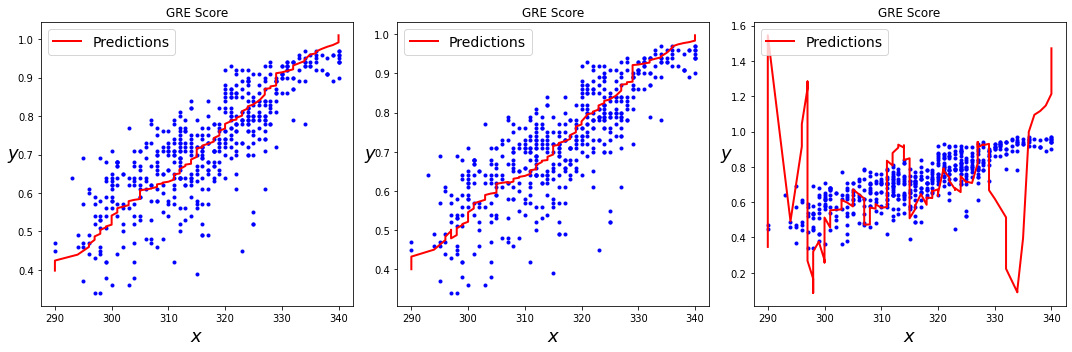

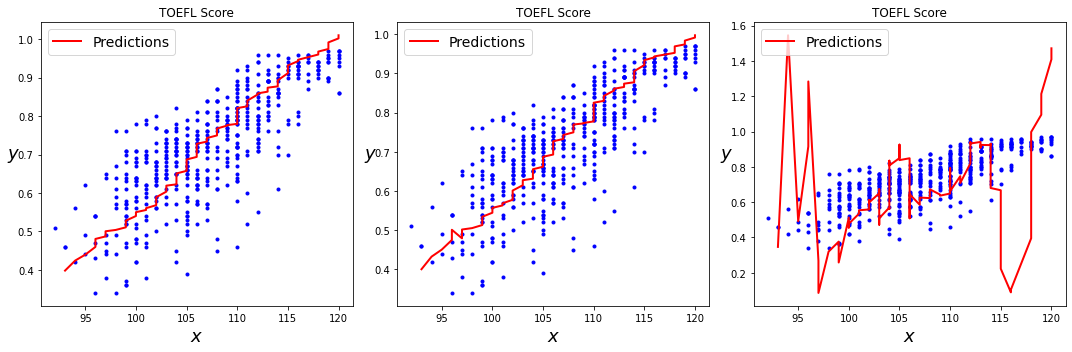

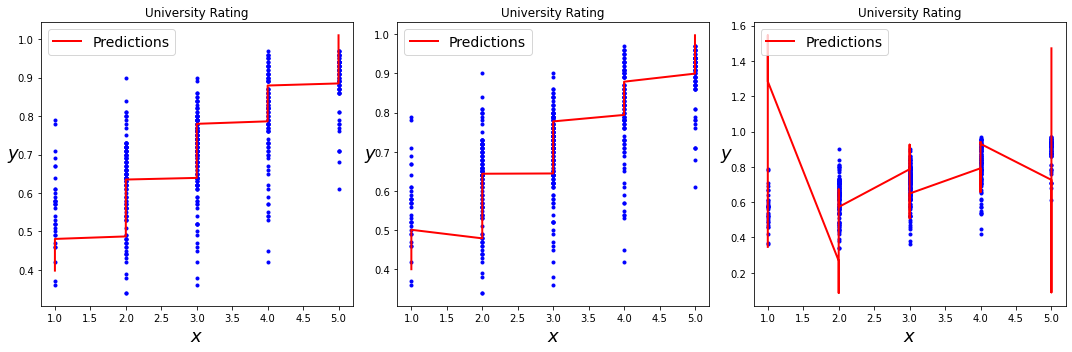

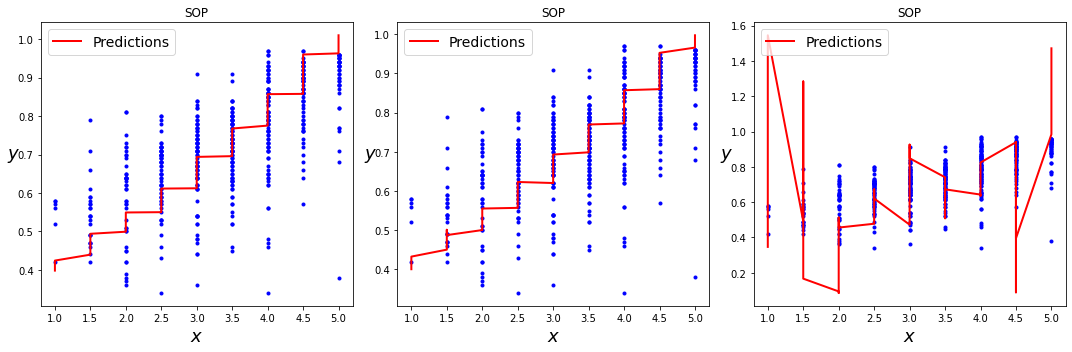

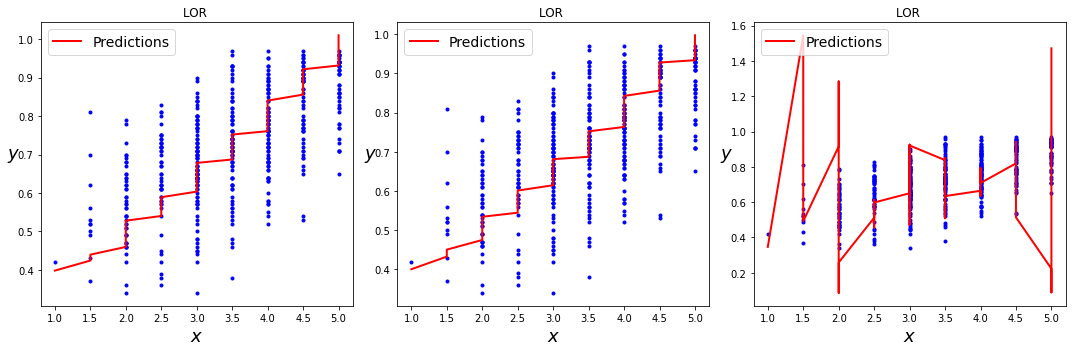

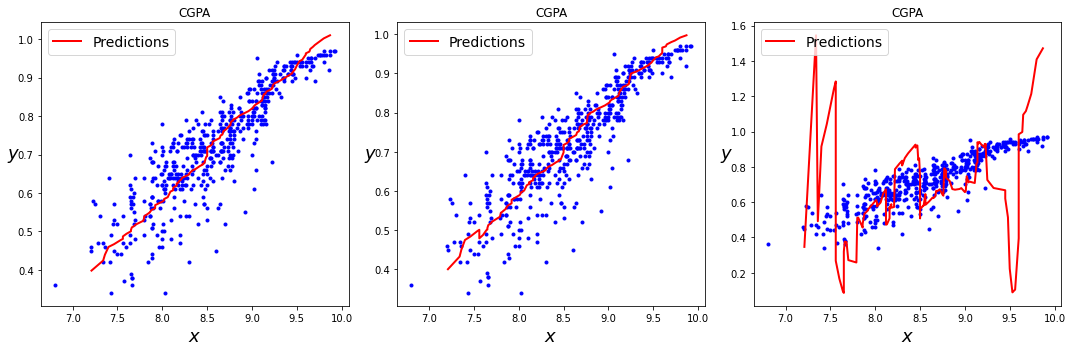

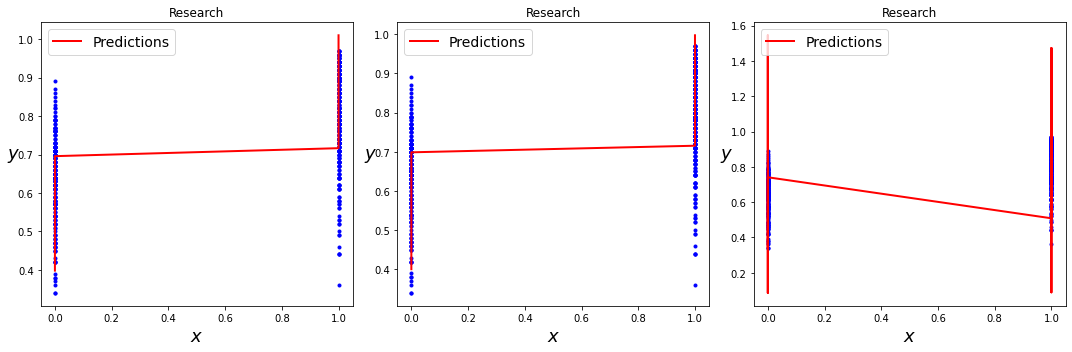

In [ ]:
l = LABELS[0] # "all"
for col_name in X_train[l].columns:
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plotOneDimension(X, y, X_test[l], y_pred[l], col_name)
  plt.subplot(1, 3, 2)
  plotOneDimension(X, y, X_test[l], y_pred_poly[2][l], col_name)
  plt.subplot(1, 3, 3)
  plotOneDimension(X, y, X_test[l], y_pred_poly[MAX_DEGREE][l], col_name)

Liniar regression and degree 2 polynomial regression are similar, with a few differences here and there, and make pretty good aproximations.

What is interesting to see is what happens with the degree 10 polynomial regression. The assumptions are very wild and some of them compleatly off the mark. Its accuracy for the median values is somewhat decent, but closer to the edge values it becomes abysmal.

This is a consequence of overfitting a polynomial regression, something that should be avoided.

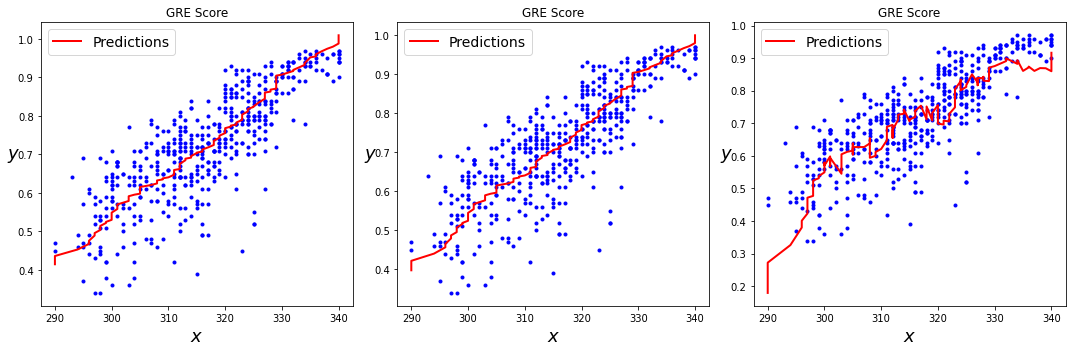

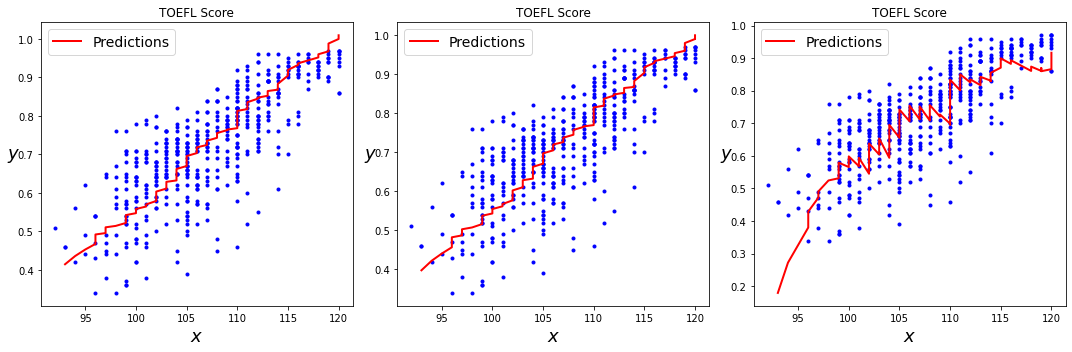

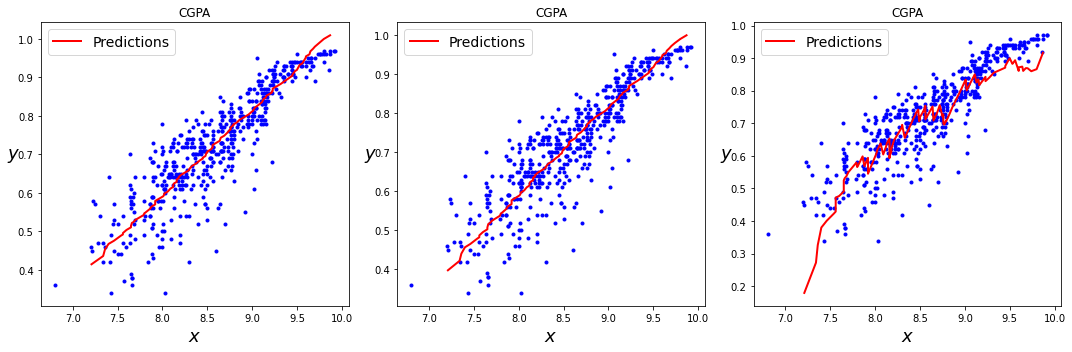

In [ ]:
l = LABELS[1] # "high_corel"
for col_name in X_train[l].columns:
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plotOneDimension(X, y, X_test[l], y_pred[l], col_name)
  plt.subplot(1, 3, 2)
  plotOneDimension(X, y, X_test[l], y_pred_poly[2][l], col_name)
  plt.subplot(1, 3, 3)
  plotOneDimension(X, y, X_test[l], y_pred_poly[MAX_DEGREE][l], col_name)

In this case, once again, liniar regression and degree 2 polynomial regression are similar in their predictions. The 10th degree polynomial regression got a lot better, though it still suffers from overfitting, evidentiated by the edge falues.

Ignoring the lower corelation data appears to push our model towards more accurate predictions, though keep in mind that this is only an eye measurement and we must check the mathematical results before we take it for granted.

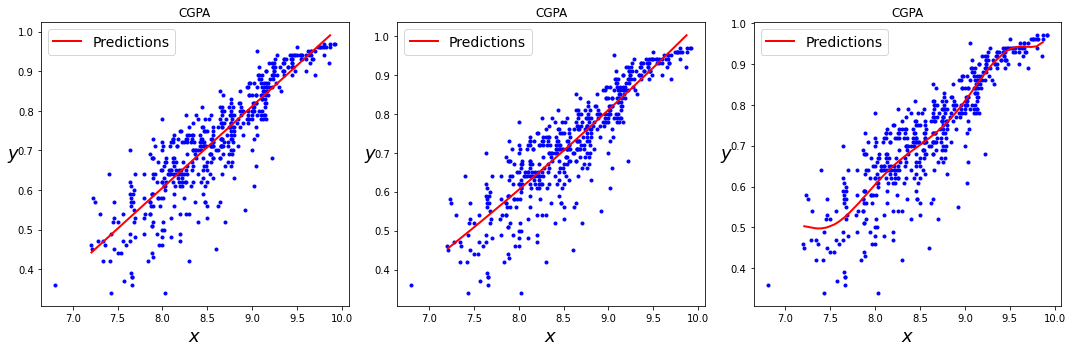

In [ ]:
l = LABELS[2] # CGPA
for col_name in X_train[l].columns:
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plotOneDimension(X, y, X_test[l], y_pred[l], col_name)
  plt.subplot(1, 3, 2)
  plotOneDimension(X, y, X_test[l], y_pred_poly[2][l], col_name)
  plt.subplot(1, 3, 3)
  plotOneDimension(X, y, X_test[l], y_pred_poly[MAX_DEGREE][l], col_name)

This is a simple, one dimensional, case where we can clearly see the straight line of a liniar regression.

The 2nd degree polynomial regression has a slight curvature, but it is otherwise close to the liniar one, reinforcing the fact that the simple and resource conservative liniar regression is enough to get satisfying results.

The 10th degree polynomial shines in comparison to its previous resoults. The multiple curves allow it to stick a lot closer to the real solutions compared to the other 2. In this case, it is no longer overfitted, and is likely to be the most accurate.

Now, lets see their results in a number format, and get a clear answer on which model performed the best.

In [ ]:
from sklearn.metrics import (mean_squared_error,
                             max_error,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             r2_score)

In [ ]:
def make_metrics_table(fct):
  results = {}

  for l in LABELS:
    results[l] = {}
    results[l]["liniar"] = fct(y_test, y_pred[l])
    for i in range(2, MAX_DEGREE + 1):
      results[l][f"polynomial {i}"] = fct(y_test, y_pred_poly[i][l])

  return pd.DataFrame(results)

In [ ]:
print("max_error:")
result = make_metrics_table(max_error)
m = result.min()
mtag = result.idxmin()
mins = []
for l, (i, j) in enumerate(zip(m, mtag)):
  mins.append((LABELS[l], j, i))
  print(mins[len(mins) - 1])

print()
the_min = mins[0][2]
if the_min > mins[1][2]:
  if mins[1][2] > mins[2][2]:
    print("winner: ", mins[2][1], mins[2][0])
  else:
    print("winner: ", mins[1][1], mins[1][0])
else:
  if mins[0][2] > mins[2][2]:
    print("winner: ", mins[2][1], mins[2][0])
  else:
    print("winner: ", mins[0][1], mins[0][0])

result

max_error:
('all', 'polynomial 2', 0.6141285748701447)
('high_corel', 'polynomial 6', 0.5885902970085363)
('CGPA', 'polynomial 10', 0.5824017075034499)

winner:  polynomial 10 CGPA


,all,high_corel,CGPA
liniar,0.614565,0.607893,0.585446
polynomial 2,0.614129,0.599349,0.592173
polynomial 3,0.619938,0.598213,0.586010
polynomial 4,1.257111,0.590576,0.586389
polynomial 5,0.778992,0.590312,0.592405
polynomial 6,0.815193,0.588590,0.601869
polynomial 7,0.813507,0.629227,0.583990
polynomial 8,0.800375,0.613500,0.583238
polynomial 9,0.842681,0.657510,0.582483
polynomial 10,0.875774,0.750468,0.582402


As expected, degree 10 polynomial regression has the lowest maximum error, as it is not cluttered by irelevant information, and it's high degree allows for predictions that are the closest to the most points.

In [ ]:
print("mean_absolute_error:")
result = make_metrics_table(mean_absolute_error)
m = result.min()
mtag = result.idxmin()
mins = []
for l, (i, j) in enumerate(zip(m, mtag)):
  mins.append((LABELS[l], j, i))
  print(mins[len(mins) - 1])

print()
the_min = mins[0][2]
if the_min > mins[1][2]:
  if mins[1][2] > mins[2][2]:
    print("winner: ", mins[2][1], mins[2][0])
  else:
    print("winner: ", mins[1][1], mins[1][0])
else:
  if mins[0][2] > mins[2][2]:
    print("winner: ", mins[2][1], mins[2][0])
  else:
    print("winner: ", mins[0][1], mins[0][0])

result

mean_absolute_error:
('all', 'polynomial 3', 0.15648991492782666)
('high_corel', 'polynomial 10', 0.14716955515622868)
('CGPA', 'polynomial 9', 0.14734250143628838)

winner:  polynomial 10 high_corel


,all,high_corel,CGPA
liniar,0.157755,0.152464,0.147355
polynomial 2,0.156968,0.152571,0.147512
polynomial 3,0.156490,0.152795,0.147991
polynomial 4,0.169652,0.153653,0.147711
polynomial 5,0.186999,0.155420,0.147769
polynomial 6,0.198020,0.157445,0.148235
polynomial 7,0.205772,0.158369,0.147387
polynomial 8,0.212220,0.158486,0.147389
polynomial 9,0.217902,0.159408,0.147343
polynomial 10,0.221957,0.147170,0.147374


The smallest mean absolute error is found in the 10th degree polynomial of the high_corel dataset. This, however, could have been just a stroke of luck, as the other values from high_corel are significantly bigger.

Because of this, an honorable mention is needed, that beeing the CGPA only models, where the 9th degree polynomial performed the best, followed by the liniar regression and then the 10th degree polynomial.

Overall, CGPA models where close for this metric, and far better than the other sets.

In [ ]:
print("mean_squared_error:")
result = make_metrics_table(mean_squared_error)
m = result.min()
mtag = result.idxmin()
mins = []
for l, (i, j) in enumerate(zip(m, mtag)):
  mins.append((LABELS[l], j, i))
  print(mins[len(mins) - 1])

print()
the_min = mins[0][2]
if the_min > mins[1][2]:
  if mins[1][2] > mins[2][2]:
    print("winner: ", mins[2][1], mins[2][0])
  else:
    print("winner: ", mins[1][1], mins[1][0])
else:
  if mins[0][2] > mins[2][2]:
    print("winner: ", mins[2][1], mins[2][0])
  else:
    print("winner: ", mins[0][1], mins[0][0])

result

mean_squared_error:
('all', 'polynomial 2', 0.040812384222100026)
('high_corel', 'polynomial 10', 0.03859287122519958)
('CGPA', 'polynomial 4', 0.03645848557051255)

winner:  polynomial 4 CGPA


,all,high_corel,CGPA
liniar,0.041433,0.039149,0.036468
polynomial 2,0.040812,0.039357,0.036532
polynomial 3,0.040891,0.039302,0.036563
polynomial 4,0.055857,0.040075,0.036458
polynomial 5,0.059359,0.040988,0.036732
polynomial 6,0.069676,0.042353,0.036934
polynomial 7,0.076428,0.043435,0.036623
polynomial 8,0.079781,0.043222,0.036624
polynomial 9,0.084527,0.044063,0.036599
polynomial 10,0.088291,0.038593,0.036615


The mean squared error is similar tot the mean absolute error, just that it evidentiates the greater errors by squaring them.

The best model in this sense is polynomial 4 of CGPA only, but it is worth noting that it opposed the trend of getting a worse score the higher the degree and could have been just luck.

The next one would be the liniar regression of CGPA, which I would consider the safest choice for this metric.

In [ ]:
print("r2_score:")
result = make_metrics_table(r2_score)
m = result.max()
mtag = result.idxmax()
maxs = []
for l, (i, j) in enumerate(zip(m, mtag)):
  maxs.append((LABELS[l], j, i))
  print(maxs[len(maxs) - 1])

print()
if maxs[0][2] < maxs[1][2]:
  if maxs[1][2] < maxs[2][2]:
    print("winner: ", maxs[2][1], maxs[2][0])
  else:
    print("winner: ", maxs[1][1], maxs[1][0])
else:
  if maxs[0][2] < maxs[2][2]:
    print("winner: ", maxs[2][1], maxs[2][0])
  else:
    print("winner: ", maxs[0][1], maxs[0][0])

result

r2_score:
('all', 'polynomial 2', -0.9581739938663585)
('high_corel', 'polynomial 10', -0.8516819887453893)
('CGPA', 'polynomial 4', -0.749274384741055)

winner:  polynomial 4 CGPA


,all,high_corel,CGPA
liniar,-0.987937,-0.878376,-0.749741
polynomial 2,-0.958174,-0.888336,-0.752780
polynomial 3,-0.961967,-0.885687,-0.754273
polynomial 4,-1.679991,-0.922798,-0.749274
polynomial 5,-1.848028,-0.966618,-0.762405
polynomial 6,-2.343026,-1.032073,-0.772099
polynomial 7,-2.667029,-1.083987,-0.757147
polynomial 8,-2.827865,-1.073769,-0.757194
polynomial 9,-3.055577,-1.114147,-0.756004
polynomial 10,-3.236171,-0.851682,-0.756787


R2 (R squared) score determines how well the regression predictions approximate the real data points. **This is considered to be the accuracy measurement of regression models.** Apparenly, it is negative because the model is not that great at predicting acurately, but hey, it is the best I can do and it is the nature of this data.

The winner in this regard is again polynomial 4 of CGPA, once again an unexpected result that opposes the trend.

The next one is liniar regression of CGPA, which would again be the best in most circumstances regarding this metric.

# 8) Conclusions

The linear regression model that considers only the CGPA column appears to be the closest and safest bet when trying to predict the admission chance for this problem and data set.

4th degree polynomial regression of CGPA performed unexpectedly well, but this is unlikely to repeat with different training and testing sets.

10th degree polynomial regression of CGPA would be the best if the most imporataint thing is a small maximum error and mean absolute error.

Overall, the all data columns models performed the worst, while CGPA only models performed the best.

In this analysis, we have learned the dangers of overfitting polynomial regressions by giving them a higher degree than needed, and that, sometimes, liniar regression is better than its more complex siblings. Also, using less data could bring far better results than using more.

Remember, more data dosen't make a model better if it is bad data.